In [1]:
import sys, os, re, jax
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))

from matplotlib import pyplot as plt
import numpy as np

from plot_helpers import (
    open_from_dir,
    plot_runs,
    plot_runs_1D,
    plot_grid,
    grid_grouped_params,
    select_best_runs,
    extract_time_constants,
    sort_by,
    _labels_from_params,
)

In [2]:
dir_ = "./04_results"
favour_oscillations = lambda fidelities: np.mean([np.max(fidelities[i:i+4]) for i in range(0, len(fidelities), 4)])
# exclude any file whose name contains "s=0"
fidelities_mat, params_grouped, params_each = open_from_dir(dir_ + "/eval")#, exclude=r".*s=4.*")
fidelities_best_mat, params_grouped_best, params_each_best = select_best_runs(fidelities_mat, params_each, objective_fun=favour_oscillations)

Opening files...


100%|██████████| 732/732 [00:00<00:00, 1034.65it/s]


Done.


Text(0.5, 1.0, 'Fidelity over Time for all runs')

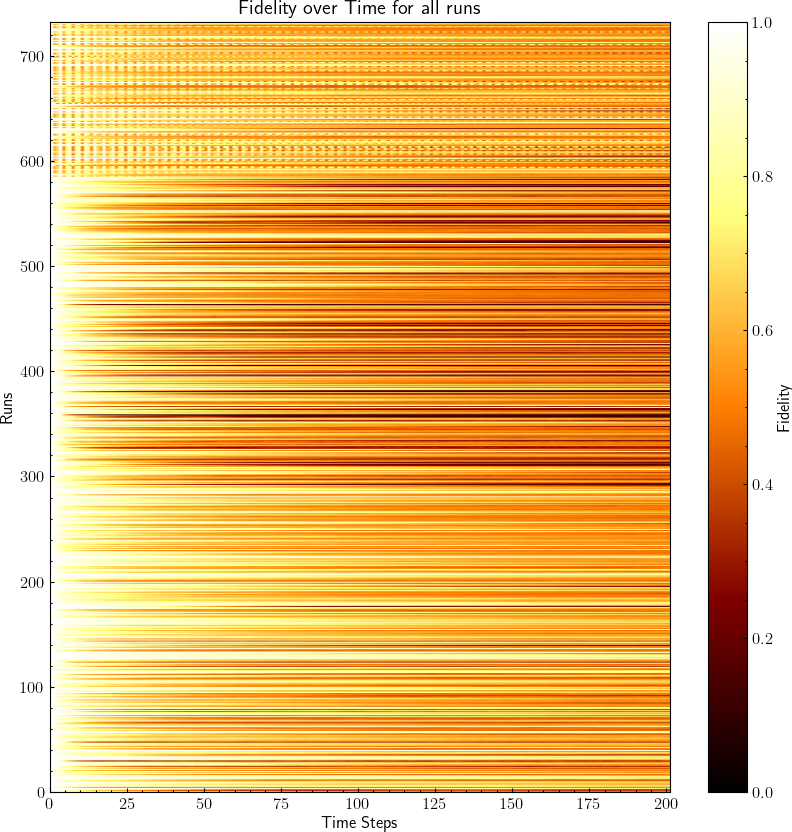

In [3]:
fig, ax, im = plot_runs(
    fidelities_mat,
    params_grouped,
    sort_by="s",
    show_labels=False,
    figsize=(10,10),
)
ax.set_title("Fidelity over Time for all runs")

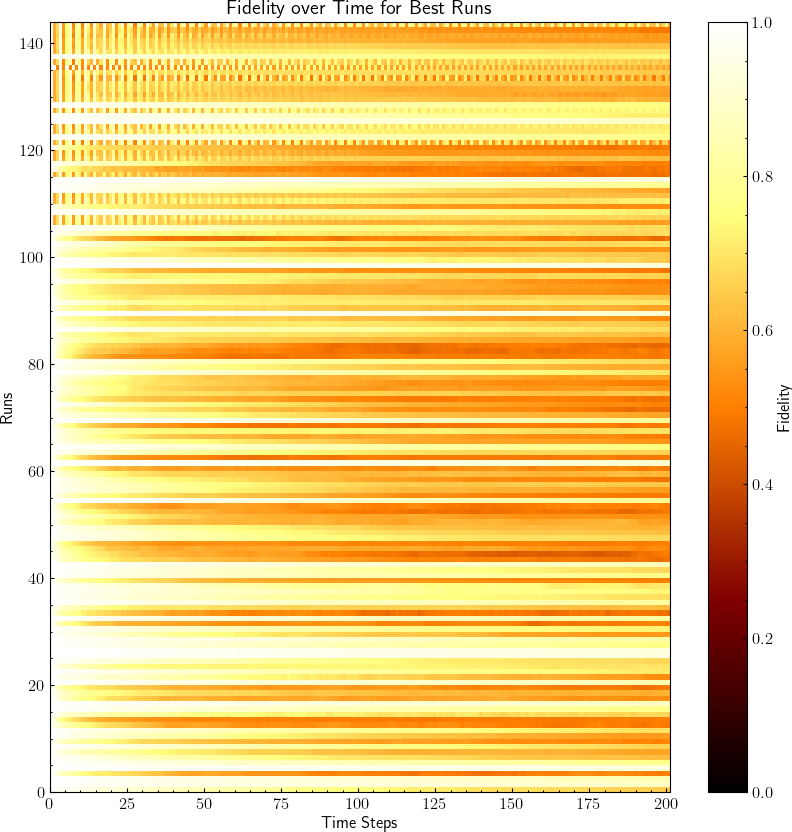

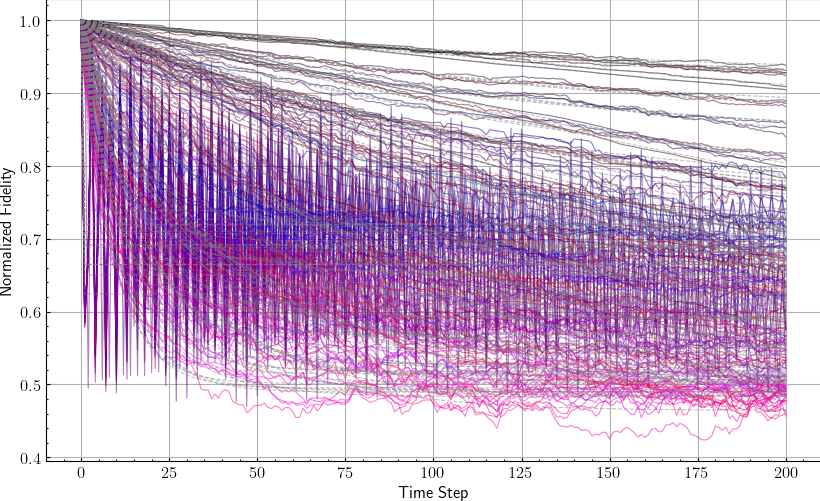

In [4]:
fig, ax, im = plot_runs(
    fidelities_best_mat,
    params_grouped_best,
    sort_by="s",
    show_labels=False,
    figsize=(10,10),
)
ax.set_title("Fidelity over Time for Best Runs")

N = 20  # Number of runs to plot with exponential fits

exp_fits = extract_time_constants(fidelities_best_mat)

idx = np.arange(fidelities_best_mat.shape[0]) #np.random.choice(fidelities_best_mat.shape[0], N, replace=False)
fig, ax = plot_runs_1D(
    fidelities_best_mat[idx],
    {param: [params_grouped_best[param][i] for i in idx] for param in params_grouped_best},
    figsize=(10,6),
)

for i in idx:
    a = exp_fits[0][i]
    tau = exp_fits[1][i]
    time_steps = np.arange(fidelities_best_mat.shape[1])
    fit = a * np.exp(-time_steps / tau) + (1 - a)
    ax.plot(time_steps, fit, "--", color="gray", alpha=0.5)

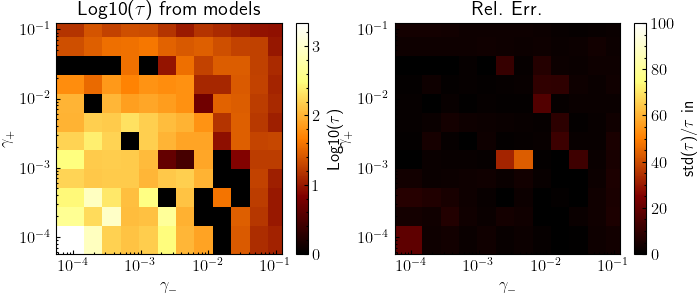

In [5]:
gamma_m_values, gamma_p_values, tau_grid = grid_grouped_params(exp_fits[1], params_grouped_best, "gammam", "gammap")
_, _, tau_err_grid = grid_grouped_params(exp_fits[3]/exp_fits[1], params_grouped_best, "gammam", "gammap")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
im = ax1.pcolormesh(
    gamma_m_values,
    gamma_p_values,
    np.log10(tau_grid),
    cmap='afmhot',
    vmin = 0,
)
ax1.set_xlabel("$\\gamma_-$")
ax1.set_ylabel("$\\gamma_+$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Log10($\\tau$) from models")
fig.colorbar(im, ax=ax1, label="Log10($\\tau$)")

im = ax2.pcolormesh(
    gamma_m_values,
    gamma_p_values,
    tau_err_grid * 100,
    cmap='afmhot',
    vmin = 0,
    vmax = 100,
)
ax2.set_xlabel("$\\gamma_-$")
ax2.set_ylabel("$\\gamma_+$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Rel. Err.")
fig.colorbar(im, ax=ax2, label="std($\\tau$)/$\\tau$ in %")

Opening files...


100%|██████████| 144/144 [00:00<00:00, 1465.47it/s]

Done.


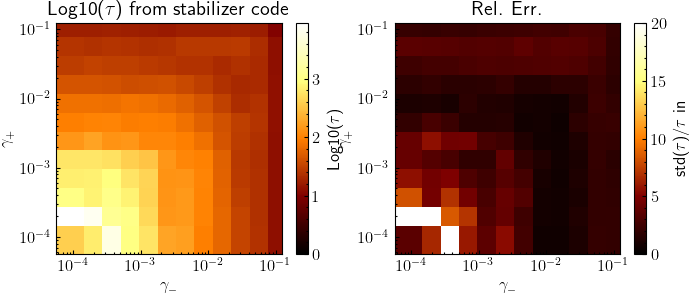

In [6]:
fidelities_mat_stab, params_grouped_stab, params_each_stab = open_from_dir(dir_ + "/custom/Stabilizer code")
fidelities_mat_stab, params_grouped_stab, params_each_stab = sort_by(fidelities_mat_stab, params_each_stab, params_each_best, ignored_keys=["s", "rhoe"]) # to have same order as before. Ignore rhoe because of bug in saving stabilizer params

exp_fits_stab = extract_time_constants(fidelities_mat_stab)

gamma_m_values_stab, gamma_p_values_stab, tau_grid_stab = grid_grouped_params(exp_fits_stab[1], params_grouped_stab, "gammam", "gammap")
_, _, tau_err_grid_stab = grid_grouped_params(exp_fits_stab[3]/exp_fits_stab[1], params_grouped_stab, "gammam", "gammap")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
im = ax1.pcolormesh(
    gamma_m_values_stab,
    gamma_p_values_stab,
    np.log10(tau_grid_stab),
    cmap='afmhot',
    vmin = 0,
)
ax1.set_xlabel("$\\gamma_-$")
ax1.set_ylabel("$\\gamma_+$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Log10($\\tau$) from stabilizer code")
fig.colorbar(im, ax=ax1, label="Log10($\\tau$)")

im = ax2.pcolormesh(
    gamma_m_values_stab,
    gamma_p_values_stab,
    tau_err_grid_stab * 100,
    cmap='afmhot',
    vmin = 0,
    vmax = 20,
)
ax2.set_xlabel("$\\gamma_-$")
ax2.set_ylabel("$\\gamma_+$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Rel. Err.")
fig.colorbar(im, ax=ax2, label="std($\\tau$)/$\\tau$ in %")

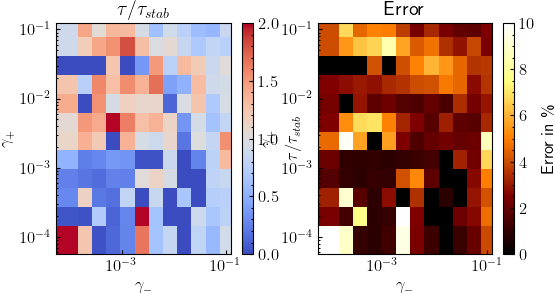

In [7]:
assert np.allclose(gamma_m_values, gamma_m_values_stab)
assert np.allclose(gamma_p_values, gamma_p_values_stab)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6.1811,3))
im = ax1.pcolormesh(
    gamma_m_values,
    gamma_p_values,
    tau_grid / tau_grid_stab,
    cmap='coolwarm',
    vmin=0,
    vmax=2,
)
ax1.set_xlabel("$\\gamma_-$")
ax1.set_ylabel("$\\gamma_+$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("$\\tau$/$\\tau_{stab}$")
fig.colorbar(im, ax=ax1, label="$\\tau$/$\\tau_{stab}$")

err_grid = tau_grid / tau_grid_stab * np.sqrt( tau_err_grid**2 + tau_err_grid_stab**2 )
#err_grid = np.abs(err_grid / (tau_grid / tau_grid_stab))
im = ax2.pcolormesh(
    gamma_m_values,
    gamma_p_values,
    err_grid * 100,
    cmap='afmhot',
    vmin = 0,
    vmax = 10,
)
ax2.set_xlabel("$\\gamma_-$")
ax2.set_ylabel("$\\gamma_+$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Error")
fig.colorbar(im, ax=ax2, label="Error in \\%%")

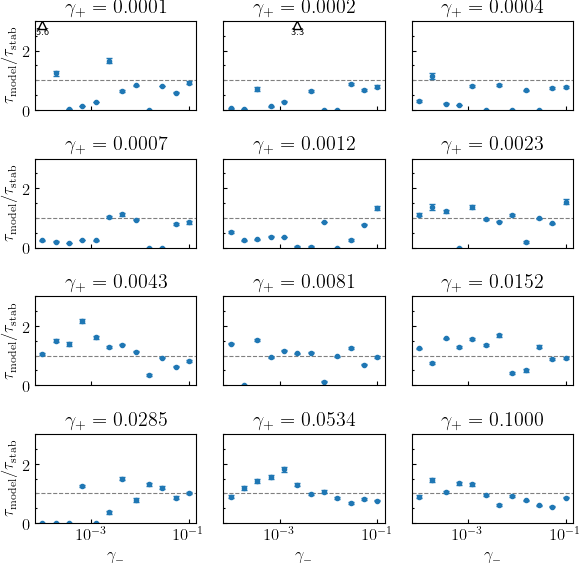

In [8]:
y_max = 3
columns = 3

fig, axs = plt.subplots(len(gamma_m_values)//columns, columns, figsize=(6.1811, len(gamma_m_values)*3/4/1.5), sharey=True, sharex=True)
axs = axs.flatten()
for i, (ax, gamma_p) in enumerate(zip(axs, gamma_p_values)):
    y = tau_grid[i,:]/tau_grid_stab[i,:]
    err = err_grid[i,:]
    mask = y < y_max*0.98

    ax.axhline(1, color="gray", ls="--")
    ax.errorbar(gamma_m_values[mask], y[mask], yerr=err[mask], fmt=".")

    #ax.annotate("$\\gamma_+ = {:.4f}$".format(gamma_p), xy=(0.5, 0.9), xycoords='axes fraction')
    # for masked data points, indicate that they are out of bounds
    for x1,y1 in zip(gamma_m_values[~mask], y[~mask]):
        ax.scatter(x1, y_max*0.95, marker="^", color="black", facecolors="none")
        ax.annotate(f"{y1:.1f}", xy=(x1, y_max*0.85), xycoords='data', color="black", ha="center", fontsize=7)

    ax.set_xscale("log")
    ax.set_title("$\\gamma_+ = {:.4f}$".format(gamma_p))

    if i % columns == 0:
        ax.set_ylabel("$\\tau_{\\rm{model}}/\\tau_{\\rm{stab}}$")
    if i >= len(gamma_m_values) - columns:
        ax.set_xlabel("$\\gamma_-$")


axs[0].set_ylim(ymin=0, ymax=y_max)
fig.tight_layout()
fig.savefig("test.svg")

Opening files...


100%|██████████| 144/144 [00:00<00:00, 3840.08it/s]

Done.


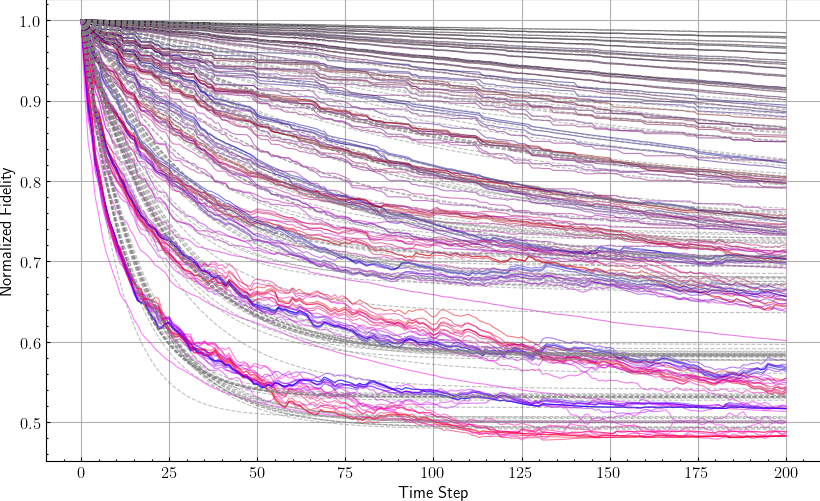

In [9]:
fidelities_mat_base, params_grouped_base, params_each_base = open_from_dir(dir_ + "/baseline")

idx = np.arange(fidelities_mat_stab.shape[0])
fig, ax = plot_runs_1D(
    fidelities_mat_stab[idx],
    {param: [params_grouped_stab[param][i] for i in idx] for param in params_grouped_stab},
    figsize=(10,6),
)

for i in idx:
    a = exp_fits_stab[0][i]
    tau = exp_fits_stab[1][i]
    time_steps = np.arange(fidelities_mat_stab.shape[1])
    fit = a * np.exp(-time_steps / tau) + (1 - a)
    ax.plot(time_steps, fit, "--", color="gray", alpha=0.5)

Text(0.5, 1.0, 'Model fidelities')

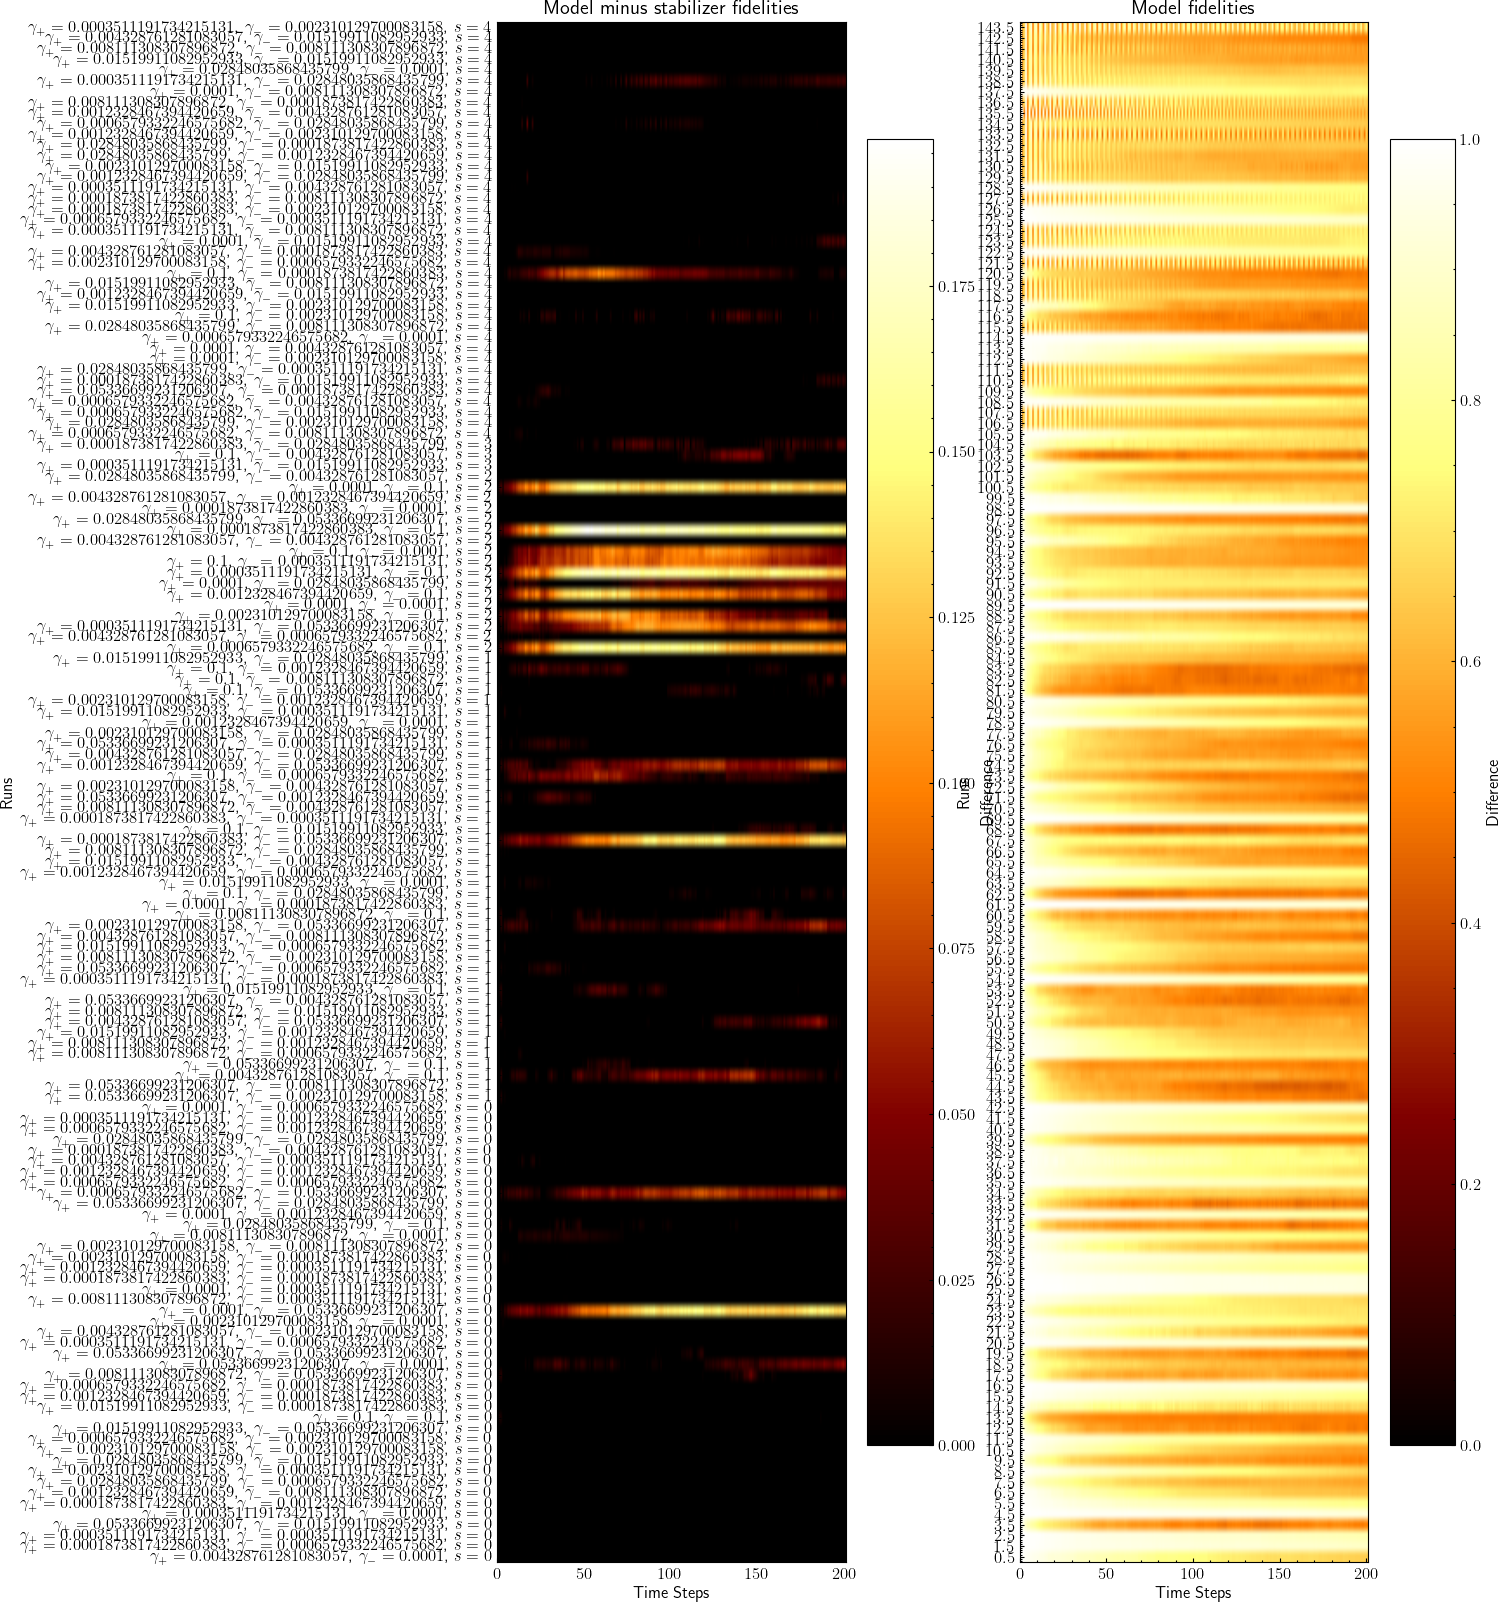

In [10]:
fidelities_diff = fidelities_best_mat - fidelities_mat_stab

labels = _labels_from_params(params_grouped_best, show_s=True)

idx = np.argsort(params_grouped_best["s"])
labels = [labels[i] for i in idx]
fidelities_diff = fidelities_diff[idx, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.1811*2, 20))
im1 = ax1.imshow(
    fidelities_diff, aspect='auto', origin='lower', 
    extent=[0, fidelities_diff.shape[1], 0, fidelities_diff.shape[0]],
    vmin=0, vmax=None,
    cmap='afmhot',
    interpolation=None,
)
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Runs")
fig.colorbar(im1, ax=ax1, label="Difference")
ax1.set_yticks(np.arange(len(labels)) + 0.5)
ax1.set_yticklabels(labels)
ax1.set_title("Model minus stabilizer fidelities")

im2 = ax2.imshow(
    fidelities_best_mat[idx, :], aspect='auto', origin='lower', 
    extent=[0, fidelities_best_mat.shape[1], 0, fidelities_best_mat.shape[0]],
    vmin=0, vmax=None,
    cmap='afmhot',
    interpolation=None,
)
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Runs")
fig.colorbar(im2, ax=ax2, label="Difference")
ax2.set_yticks(np.arange(len(labels)) + 0.5)
ax2.set_title("Model fidelities")